In [1]:
import sys
from pathlib import Path

project_root = Path().resolve().parent
sys.path.append(str(project_root / "src"))

In [ ]:
from config.db import SQLITEConfig
import sqlite3

print(f"Using DB at: {SQLITEConfig.get_db_path()}")

In [3]:
conn = sqlite3.connect(SQLITEConfig.get_db_path())
c = conn.cursor()

In [4]:
c.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = c.fetchall()
print("Tables:", tables)


Tables: [('functions',), ('sqlite_sequence',), ('functions_metadata',), ('injections',), ('validations',), ('researches',), ('condenser',)]


In [5]:
c.execute("""
    SELECT cwe_label, COUNT(*) AS count
    FROM validations
    WHERE is_valid = 1
    GROUP BY cwe_label
    ORDER BY count DESC;
""")
cwe_counts = {cwe_label: count for cwe_label, count in c.fetchall()}


In [6]:
# Distinct injected cwes
print(len(cwe_counts))

67


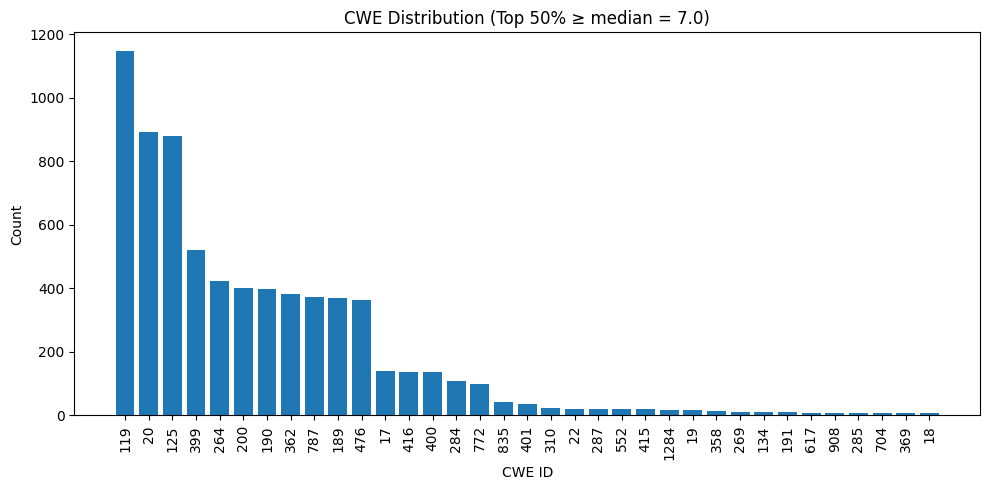

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Sort by count descending
cwe_counts = dict(sorted(cwe_counts.items(), key=lambda x: x[1], reverse=True))

# Extract values and compute median
values = list(cwe_counts.values())
median_val = np.median(values)

# Filter CWEs with counts >= median
filtered = {k: v for k, v in cwe_counts.items() if v >= median_val}

# Simplify labels: keep only number part
labels = [label.split('-')[-1] for label in filtered.keys()]
values = list(filtered.values())

# Plot
plt.figure(figsize=(10, 5))
plt.bar(labels, values)

plt.title(f"CWE Distribution (Top 50% ≥ median = {median_val})")
plt.xlabel("CWE ID")
plt.ylabel("Count")

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [8]:
import pandas as pd

df_counts = pd.read_sql_query("""
SELECT v.func_name,
       COUNT(i.id) AS injection_count
FROM validations v
JOIN injections i ON v.func_name = i.func_name
WHERE v.is_valid = 1
GROUP BY v.func_name
""", conn)

In [9]:
df_cwe = pd.read_sql_query("""
SELECT func_name,
       cwe_label
FROM validations
WHERE is_valid = 1
""", conn)

# choose the most frequent CWE per function
dominant_cwe = (
    df_cwe.groupby("func_name")["cwe_label"]
    .agg(lambda x: x.value_counts().idxmax())
    .reset_index()
)


In [10]:
df = df_counts.merge(dominant_cwe, on="func_name", how="left")

In [11]:
import pandas as pd
import numpy as np

def stratified_weighted_sample(df, n=100, min_per_cwe=2, random_state=42):
    np.random.seed(random_state)
    sampled = []

    # total per-CWE counts
    cwe_counts = df["cwe_label"].value_counts(normalize=True)

    # compute target number per stratum
    for cwe, proportion in cwe_counts.items():
        group = df[df["cwe_label"] == cwe]
        # target number of samples per CWE (at least min_per_cwe)
        n_cwe = max(int(round(proportion * n)), min_per_cwe)
        n_cwe = min(n_cwe, len(group))  # can’t exceed available items

        # weights inversely proportional to injection_count
        weights = 1 / (group["injection_count"] + 1e-6)
        weights /= weights.sum()

        sample_cwe = group.sample(n=n_cwe, weights=weights, random_state=np.random.randint(1e6))
        sampled.append(sample_cwe)

    sampled_df = pd.concat(sampled, ignore_index=True)
    return sampled_df

sampled_df = stratified_weighted_sample(df, n=100)
print(sampled_df["cwe_label"].value_counts(normalize=True))
print(len(set(sampled_df['cwe_label'])))


cwe_label
CWE-119    0.128788
CWE-20     0.098485
CWE-125    0.075758
CWE-264    0.053030
CWE-476    0.053030
CWE-200    0.053030
CWE-190    0.045455
CWE-399    0.045455
CWE-189    0.045455
CWE-362    0.037879
CWE-787    0.030303
CWE-284    0.015152
CWE-400    0.015152
CWE-17     0.015152
CWE-416    0.015152
CWE-772    0.015152
CWE-401    0.015152
CWE-415    0.015152
CWE-287    0.015152
CWE-835    0.015152
CWE-404    0.015152
CWE-358    0.015152
CWE-310    0.015152
CWE-617    0.015152
CWE-18     0.015152
CWE-552    0.015152
CWE-908    0.015152
CWE-191    0.007576
CWE-19     0.007576
CWE-120    0.007576
CWE-252    0.007576
CWE-667    0.007576
CWE-78     0.007576
CWE-755    0.007576
CWE-843    0.007576
CWE-193    0.007576
CWE-285    0.007576
CWE-22     0.007576
CWE-59     0.007576
Name: proportion, dtype: float64
39


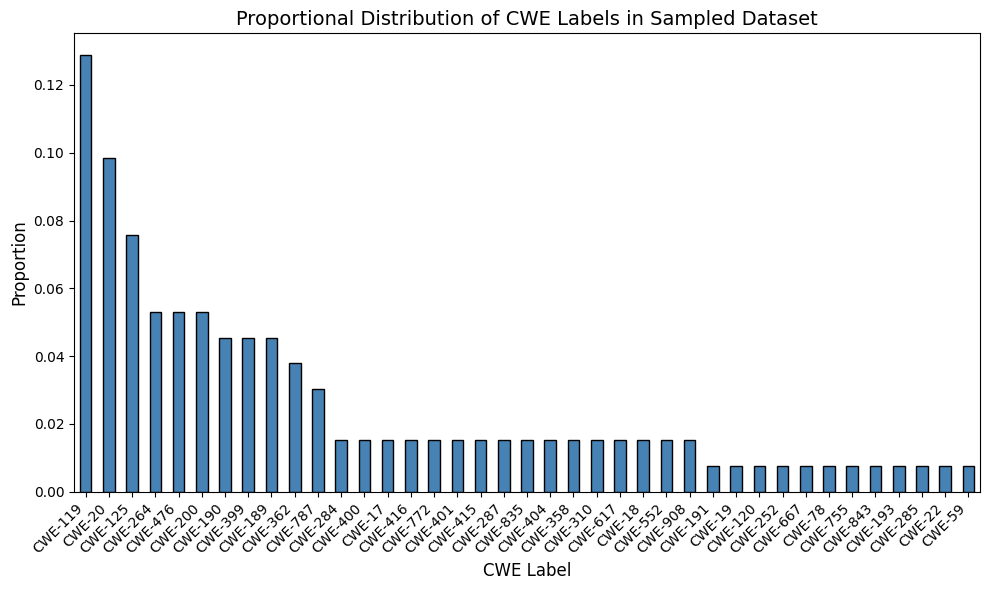

In [12]:
import matplotlib.pyplot as plt

# Get normalized proportions
cwe_dist = sampled_df["cwe_label"].value_counts(normalize=True).sort_values(ascending=False)

# Plot as bar chart
plt.figure(figsize=(10, 6))
cwe_dist.plot(kind="bar", color="steelblue", edgecolor="black")

# Add labels and title
plt.title("Proportional Distribution of CWE Labels in Sampled Dataset", fontsize=14)
plt.xlabel("CWE Label", fontsize=12)
plt.ylabel("Proportion", fontsize=12)
plt.xticks(rotation=45, ha="right")

# # Add percentage labels above bars
# for i, val in enumerate(cwe_dist):
#     plt.text(i, val + 0.005, f"{val*100:.1f}%", ha="center", fontsize=10)

plt.tight_layout()
plt.show()


In [13]:
import os

bigvul_ds_path = r"E:\Learning Projects\Machine Learning\ML-Model-Integrated-Projects\SophGen\train_dot\bigvul"
cvefixes_ds_path = r"E:\Learning Projects\Machine Learning\ML-Model-Integrated-Projects\SophGen\train_dot\cvefixes"

bigvul_vul_path = os.path.join(bigvul_ds_path, "bigvul_vul")
bigvul_nonvul_path = os.path.join(bigvul_ds_path, "bigvul_nonvul")

cvefixes_vul_path = os.path.join(cvefixes_ds_path, "cvefixes_vul")
cvefixes_nonvul_path = os.path.join(cvefixes_ds_path, "cvefixes_nonvul")


def read_func_pair(func_name: str) -> dict[str, str] | None:
    """
    Returns both vulnerable and non-vulnerable versions of a function
    from either the BigVul or CVEfixes dataset.

    Looks for func_name.c in:
        - bigvul_vul / bigvul_nonvul
        - cvefixes_vul / cvefixes_nonvul

    Returns:
        dict with keys {"vul", "nonvul"} if found, else None.
    """
    filename = f"{func_name}.c"

    bigvul_vul_file = os.path.join(bigvul_vul_path, filename)
    bigvul_nonvul_file = os.path.join(bigvul_nonvul_path, filename)

    cvefixes_vul_file = os.path.join(cvefixes_vul_path, filename)
    cvefixes_nonvul_file = os.path.join(cvefixes_nonvul_path, filename)

    if os.path.exists(bigvul_vul_file) and os.path.exists(bigvul_nonvul_file):
        with open(bigvul_vul_file, "r", encoding="utf-8") as f1, \
             open(bigvul_nonvul_file, "r", encoding="utf-8") as f2:
            return {"vul": f1.read(), "nonvul": f2.read()}

    if os.path.exists(cvefixes_vul_file) and os.path.exists(cvefixes_nonvul_file):
        with open(cvefixes_vul_file, "r", encoding="utf-8") as f1, \
             open(cvefixes_nonvul_file, "r", encoding="utf-8") as f2:
            return {"vul": f1.read(), "nonvul": f2.read()}

    return None


In [14]:
from agents.tools import ValidatorTools

async def get_valid_injections(func_name: str, tools: ValidatorTools, valid_hashes:list[str]) -> list[dict]:
    injections = await tools.get_injections(func_name)
    return [inj for inj in injections if inj.get('ref_hash') in valid_hashes]

In [15]:
from agents.tools import ValidatorTools
validator_tools = ValidatorTools()

c.execute("""
    SELECT ref_hash
    FROM validations
    WHERE is_valid = 1
""")
valid_hashes = [hash[0] for hash in c.fetchall()]

In [20]:
from agents.validator import GroundTruthChecker
from services.llm import LLMService
from utils.enums import LLMModels

llm = LLMService(LLMModels.GEMINI_2_5_FLASH)
checker = GroundTruthChecker(llm)

In [21]:
import asyncio
import json
from datetime import datetime
from tqdm.asyncio import tqdm_asyncio
from tqdm import tqdm

# === CONFIG ===
LOG_FILE = "rating_log.jsonl"     # incremental log file (safe if interrupted)
INTERVAL = 5.0                    # seconds to sleep between attempts
SAVE_EVERY = 10                   # flush to disk every N entries


async def evaluate_attempts(sampled_df, checker, validator_tools, valid_hashes):
    """
    Iterates through each function name, retrieves injection attempts,
    evaluates them, and logs results to disk.
    Shows progress using tqdm.
    """
    logs = []

    func_names = sampled_df['func_name'].tolist()
    pbar = tqdm(func_names, desc="Evaluating attempts", unit="func")

    for i, func_name in enumerate(pbar, start=1):
        try:
            attempt = await get_valid_injections(func_name, validator_tools, valid_hashes)
            if not attempt:
                pbar.write(f"⚠️ No valid attempt for {func_name}")
                continue

            code_pair = read_func_pair(func_name)
            if not code_pair:
                pbar.write(f"⚠️ Missing code pair for {func_name}")
                continue

            response = await checker.run(context={
                "vul_code": code_pair["vul"],
                "benign_code": code_pair["nonvul"],
                "injection_attempt": attempt,
            })

            entry = {
                "timestamp": datetime.now().isoformat(),
                "index": i,
                "func_name": func_name,
                "valid_attempt": response.valid_attempt,
            }
            logs.append(entry)

            # Show result in tqdm bar (non-blocking)
            symbol = "✅" if response.valid_attempt else "❌"
            pbar.set_postfix_str(f"{symbol} {func_name}")

            # Periodically flush logs
            if i % SAVE_EVERY == 0:
                with open(LOG_FILE, "a", encoding="utf-8") as f:
                    for l in logs:
                        f.write(json.dumps(l) + "\n")
                logs.clear()

            await asyncio.sleep(INTERVAL)

        except Exception as e:
            pbar.write(f"❌ Error on {func_name}: {e}")
            continue

    # Final flush
    if logs:
        with open(LOG_FILE, "a", encoding="utf-8") as f:
            for l in logs:
                f.write(json.dumps(l) + "\n")

    pbar.close()
    print(f"\n✅ Evaluation complete. Results saved to {LOG_FILE}")

In [ ]:
# you can check if you're using the correct api key here
print(checker.llm.config.api_key)

In [23]:
await evaluate_attempts(sampled_df, checker, validator_tools, valid_hashes)

Evaluating attempts: 100%|██████████| 132/132 [38:07<00:00, 17.33s/func, ✅ store_xauthority_1]                                


✅ Evaluation complete. Results saved to rating_log.jsonl


In [ ]:
import json

ratings = []
with open("rating_log.jsonl", "r", encoding="utf-8") as f:
    for line in f:
        if line.strip():  # skip empty lines
            ratings.append(json.loads(line))

print(len(ratings), "entries loaded.")

132 entries loaded.


In [37]:
import math
k = len([r for r in ratings if r['valid_attempt']])
n = len(ratings)
p_hat = k / n
z = 1.96

def wilson_ci(k, n, z=1.96):
    if n == 0:
        return (0.0, 1.0)
    phat = k/n
    denom = 1 + z*z/n
    center = phat + z*z/(2*n)
    margin = z * math.sqrt((phat*(1-phat)/n) + (z*z/(4*n*n)))
    lower = (center - margin) / denom
    upper = (center + margin) / denom
    return phat, lower, upper

p_hat, lower, upper = wilson_ci(k, n, z)
print(f"p-hat = {p_hat:.3f}, 95% CI = ({lower:.3f}, {upper:.3f})")

p-hat = 0.553, 95% CI = (0.468, 0.635)


In [48]:
c.execute("""
    SELECT *
    FROM injections
""")

all_injections = c.fetchall()

In [49]:
valid_injections = [inj for inj in all_injections if inj[11] in valid_hashes]

In [ ]:
import math
from collections import Counter
import difflib

ORIG_IDX = 3
TRANS_IDX = 4

def opcode_signature(orig, trans, max_ops=10):
    """Return a compact signature string summarizing SequenceMatcher opcodes.
       We encode as TAG:length for consecutive ops, limited to max_ops tokens to avoid huge signatures.
    """
    s = difflib.SequenceMatcher(None, orig, trans)
    ops = []
    for tag, i1, i2, j1, j2 in s.get_opcodes():
        length = max(i2 - i1, j2 - j1)
        ops.append(f"{tag}:{length}")
        if len(ops) >= max_ops:
            break
    return "|".join(ops)

def diff_counts_signature(orig, trans):
    """Return counts of insert/delete/replace/equal as compact signature."""
    s = difflib.SequenceMatcher(None, orig, trans)
    counts = Counter()
    for tag, i1, i2, j1, j2 in s.get_opcodes():
        counts[tag] += max(i2 - i1, j2 - j1)
    # canonical order
    return f"rep:{counts['replace']}_del:{counts['delete']}_ins:{counts['insert']}_eq:{counts['equal']}"

def levenshtein(a, b):
    """Simple Levenshtein distance (dynamic programming). Reasonably fast for lines."""
    if a == b: return 0
    la, lb = len(a), len(b)
    if la == 0: return lb
    if lb == 0: return la
    prev = list(range(lb + 1))
    for i, ca in enumerate(a, 1):
        cur = [i] + [0]*lb
        for j, cb in enumerate(b, 1):
            cost = 0 if ca == cb else 1
            cur[j] = min(prev[j] + 1,        # deletion
                         cur[j-1] + 1,      # insertion
                         prev[j-1] + cost)  # substitution
        prev = cur
    return prev[lb]

def shannon_entropy_from_counts(counter):
    total = sum(counter.values())
    if total == 0:
        return 0.0
    import math
    ent = 0.0
    for c in counter.values():
        p = c / total
        ent -= p * math.log2(p)
    return ent

# build signatures
opcode_sigs = []
diffcount_sigs = []
lev_dists = []
for row in valid_injections:
    orig = str(row[ORIG_IDX])
    trans = str(row[TRANS_IDX])
    opcode_sigs.append(opcode_signature(orig, trans))
    diffcount_sigs.append(diff_counts_signature(orig, trans))
    lev_dists.append(levenshtein(orig, trans))

# compute frequencies and entropy
opcode_ctr = Counter(opcode_sigs)
diff_ctr = Counter(diffcount_sigs)
# Levenshtein: you can compute entropy directly on exact distances or on binned distances
lev_ctr = Counter(lev_dists)

entropy_opcode = shannon_entropy_from_counts(opcode_ctr)
entropy_diff = shannon_entropy_from_counts(diff_ctr)
entropy_lev = shannon_entropy_from_counts(lev_ctr)

effective_opcode = 2 ** entropy_opcode
effective_diff = 2 ** entropy_diff
effective_lev = 2 ** entropy_lev

print("Opcode-signature entropy: {:.3f} bits (effective diversity {:.1f})".format(entropy_opcode, effective_opcode))
print("Diff-counts entropy   : {:.3f} bits (effective diversity {:.1f})".format(entropy_diff, effective_diff))
print("Levenshtein entropy   : {:.3f} bits (effective diversity {:.1f})".format(entropy_lev, effective_lev))

print("\nTop opcode signatures:")
for sig, cnt in opcode_ctr.most_common(10):
    print(f"{cnt:5d}  {sig}")


Opcode-signature entropy: 12.609 bits (effective diversity 6247.9)
Diff-counts entropy   : 12.359 bits (effective diversity 5254.3)
Levenshtein entropy   : 6.491 bits (effective diversity 89.9)

Top opcode signatures:
   14  insert:3|equal:13|insert:35
    9  insert:3|equal:21|insert:36
    9  equal:4|replace:15|equal:1|insert:27|equal:1
    8  equal:7|replace:1|equal:1
    8  insert:3|equal:7|insert:3
    8  insert:3|equal:7|insert:49
    8  insert:3|equal:18|insert:38
    7  equal:7|replace:7|equal:1
    7  insert:3|equal:6|insert:53
    6  equal:7|replace:2|equal:1


In [65]:
import pandas as pd

mas_input = pd.read_csv("../src/scripts/data/merged_test_input.csv")

In [82]:
total_rois = 0

for index, row in mas_input.iterrows():
    total_rois += len(row['merged_roi_lines'].split('\n'))


In [83]:
total_rois

8448

In [88]:
c.execute("""
    SELECT *
    FROM validations
""")

all_validations = c.fetchall()

In [92]:
all_validations[0]

(1,
 1,
 'CWE-17',
 '2fdc99fcef82da4f',
 1,
 2,
 8,
 1,
 "The `__attribute__((deprecated))` tag marks the function as deprecated, which can lead to maintainability issues and encourage the use of potentially less secure alternatives if they exist. It's a compile-time warning, not a direct runtime exploit.",
 'Adding a GCC attribute for deprecation is a standard and natural way to indicate outdated code in C.',
 'Yes, the function will still compile and execute as before, but with a deprecation warning during compilation.',
 'The injection correctly introduces CWE-17 by marking the function as deprecated. The change is syntactically valid and within the ROI.',
 'None.',
 'aio_setup_single_vector_1',
 '2',
 '2025-11-05 16:27:33')

In [90]:
len(all_validations)

7743

In [100]:
stripped_validations = [(val[2], val[13]) for val in all_validations]

In [101]:
import pandas as pd

def calculate_all_cwe_utilization(stripped_validations, mas_input: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate CWE utilization for all functions in mas_input.

    Utilization = (validated CWEs ∩ suggested CWEs) / (suggested CWEs)
    """
    # Build DataFrame from stripped_validations
    df_valid = pd.DataFrame(stripped_validations, columns=['cwe_id', 'func_name'])

    results = []
    for _, row in mas_input.iterrows():
        func_name = row['func_name']
        suggested_cwes = set(row['cwe_ids'].split(',')) if isinstance(row['cwe_ids'], str) else set()

        # Get validated CWEs for this function
        validated_cwes = set(df_valid.loc[df_valid['func_name'] == func_name, 'cwe_id'])

        overlap = validated_cwes & suggested_cwes
        utilization = len(overlap) / len(suggested_cwes) if suggested_cwes else 0

        results.append({
            'func_name': func_name,
            'suggested_cwes': suggested_cwes,
            'validated_cwes': validated_cwes,
            'overlap': overlap,
            'utilization': round(utilization, 3),
        })

    return pd.DataFrame(results)


In [104]:
df_result = calculate_all_cwe_utilization(stripped_validations, mas_input)
df_result.head(2)

,func_name,suggested_cwes,validated_cwes,overlap,utilization
0,aio_setup_single_vector_1,"{CWE-17, CWE-399, CWE-119}","{CWE-17, CWE-399, CWE-119}","{CWE-17, CWE-399, CWE-119}",1.000
1,plot_spectrum_column-252701104198994,"{CWE-200, CWE-399, CWE-22}","{CWE-399, CWE-200}","{CWE-399, CWE-200}",0.667


In [108]:
print(df_result['utilization'].mean(), df_result['utilization'].median())

0.6997780172413793 0.75
